<a href="https://colab.research.google.com/github/vvrebellion/20191204_VITTORIA_Data-AI/blob/master/HWlesson1_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

HOMEWORK 1: Due to Sept. 21, Mon, 2020; Please provide your answers to this notebook as comments, so that the modified notebook can still be executed by the TAs and the instructor. Please submit this notebook as your homework. Note that the questions of the mid and final exams would not be so different from those of the homeworks. To submit the homeworks, please create a github repository for your homework and submit your homeworks into this repository and make your TA and teacher as contributors to the repository so that they can access it. If you have difficulty in creating your github account and repository, please consult your TA and teacher. 

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

# Question 1: 1.1) What are "packages" in Python? 

#In python, we have modules and packages. Modules and packages are useful for dividing large 
#programs into manageable and organized smaller parts. A file containing Python code is a 
#module. A package is a collection of python modules, which organizes and provides a naming 
#hierarchy to its modules. 

# 1.2) How do you import packages into your Python code? 
# cf:  https://docs.python.org/3/tutorial/modules.html#importing-from-a-package

#The import statement allows us to import packages and modules into our Python code. In this 
#case, we're also using the "from" clause to specify what we want to import: everything in 
#"fastai.vision" and the "error_rate" in "fastai.metrics"

# 1.3) In the above two statements, what does "import *" do?

#"Import *" will import everything from the designated module or package. It is usually considered 
#a bad practice but when training classification models, having everything available for you all the 
#time helps to experiment quickly. 

# 1.4) In python, every thing is called an "object" including integers, 
#real numbers, functions, classes, and instances of classes, 
# though instances of classes are special citizens of this society of objects
# and thereby often called "objects".
# Please guess what category of objects does "error_rate" belong to?

#Since the error_rate has to be calculated using different variables, I'd guess it is a function.

In [ ]:
type(error_rate)

function

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [ ]:
bs = 64
# Question 2: 2.1) What is the batch size? Note that it is used in 
# function  ImageDataBunch.from_name_re(). 
#We can divide our training dataset into smaller groups called batches, which
#defines how many images do you train at one time. The batch size, or "bs", is 
#the size of the batch in which data will be arranged, in this case, the number of images.


# 2.2) What would happen when you reduce it to 16 as in the following comment?
# bs = 16  
#The model will go through fewer images per batch and will have to go through more batches than 
#with bs = 32, so it can make the training take a bit longer. But at the same time, it can make the 
#model more accurate by lowering generalization error. Also, the batch size is set to 16 if 
#memory is not enough, so if you run out of memory, a smaller bs can solve the memory error.




## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [ ]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False, verbose=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [ ]:
path = untar_data(URLs.PETS); path
# Question 3. 3.1) What is the value of variable URLs.PETS?
#https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet

# 3.2) From which package would URLs.PETS have been imported?
#fastai.datasets

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [ ]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [ ]:
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [ ]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [ ]:
fnames = get_image_files(path_img)
fnames[:5]
# Question 4. 4.1) path_image is the path to a folder. What would be fnames?
#fnames is the list of file names in that folder

# 4.2) fnames[:5] indicates that five elements from index 0 to 4 are selected from
# fnames, whose data type is called a list. What is the length of this list?
# You can write and execute some Python statement involving fnames to know the length. 

#We can use len(fnames) to discover the length of this list, which is 7390.


# 4.3) The following is the result of executing fnames[:5]. It shows 5 image filenames.
# The filenames refer to particular images but they also contain categories or labels
# for those images. Not that our example notebook classifies a given dog or cat image into one of
# 37 categories.  Please explain how could you extract the category from a given image filename.
# You can explain by using examples. 

#We can notice that the labels are actually part of the file names in the fnames list. 
#In order to extract the label part each file name, we can use the "from_name_re. re" module.
#First, we will define the pattern "pat", a regular expression to be used to extract the label from 
#the file name, which means it will extract only the text part that satisfies the condition defined by #the pattern. 
#The regular expression is  pat = r'/([^/]+)_\d+.jpg$' and it means the label to be extracted should 
#be the text between path/ and _number.jpg. So for example, for /root/.fastai/data/oxford-iiit-pet/images/boxer_93.jpg
#the label is "boxer"


[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_70.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_73.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_14.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_16.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_181.jpg')]

In [ ]:
len(fnames)

7390

In [ ]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                  size=224, bs=bs
                                  ).normalize(imagenet_stats)
# Question 5. Let us decomppose the above statement as follows:
# (a) interMediateData = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                                    size=224, bs=bs)
# (b) data = interMediateData.normalize(imagenet_stats).          
                       )
# 5.1) What does (a) do? 
#interMediateData is the data we're using in this process. ImageDataBunch.from_name_re will 
#return a DataBunch object, the "ImageDataBunch" that represents all of the data we need to 
#build a model. The arguments used are as follows:
#path_img is a folder containing images
#fnames is a list of file names
#pat ia a pattern used to extract only the label part that satisfies the condition r'/([^/]+)_\d+.jpg$'
#The ds_tfms=get_transforms(), size=224, part makes all of your data the same size, in this case 224.
#bs=bs defines the batch size, that is, the number of images processed at a time

# 5.2) What does (b) do?              
#In machine learning we want our data to have a mean of zero and a standard deviation of 1, 
#which we can achieve through normalization. In statement (a) we have already made all of our 
#data the same size, which is a way to normalize our data. (b) is a normalize function that uses 
#the imagenet pretrained model. So instead of using the mean and standard deviations of our 
#data, we will use the mean and standard deviation of the original imagenet data to normalize 
#our data.
    
                                

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
data
# Question 6. The following is the result of executing "data". 
# It shows Train dataset and Validation dataset. The train dataset 
# or the validaton dataset consits of LabelList and CategoryList. 
# It also shows 5 examples from ImageList and CategoryList as an illustration.

# 6.1) How many items does LabelList of the Train dataset?
#5912 items as in Train: LabelList (5912 items)

# 6.2) How many items does CategoryList of the Train dataset?
#5912 items

# 6.3) How many items does LabelList of the Validation dataset?
#1478 items as in Valid: LabelList (1478 items)

# 6.4) How many items does CategoryList of the Validation dataset?
#1478 items

# (6.5) What do you obtain when you add the length of LabelList of the Train dataset
# and the length of LabelList of the Validation dataset?
#5912+1478 = 7390

# 6.6) Is it the same as the length of fnames you obtained above?
#Yes

# 6.7) What is the percentage of the length of LabelList of the Validation dataset 
#      with respect to the length of fnames? 
#20%

# 6.8) What does this percentage mean? The answer to this question should include
# the answer to the question "What the train dataset and the validation dataset
# are and how they are used in machine learning. 
#When we created our DataBunch, it automatically created a train_dl, valid_dl and test_dl. They 
#are sets of data which correspond to train, validation and test sets.  The result of executing 
#"data" shows us that our test set is empty, while the Train dataset contains 80% of fnames and 
#the Validation dataset contains 20%. The model is going to train with the Train set (80% of the 
#data), while the validation set (20% of data) is not going to be shown to the model. After the 
#training is done we can use the validation set data to know if we're overfitting, that is, to know 
#whether our model can correctly classify only the images it used to train or if it can also classify 
#images it has never seen before.



ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,great_pyrenees,english_cocker_spaniel,Ragdoll,leonberger
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
havanese,english_cocker_spaniel,leonberger,leonberger,samoyed
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# Question 7: Function cnn_learner() combines the machine learning model "resnet34" 
# with data which includes the train dataset and the validation dataset as we examined above.
# The obtained object "learn" refers to the neural network to be trained using "data".
# But models.resent34 is a pretained neural network, that is, the neural network that is 
# already trained by using one and half a million images and thousands of categories. 
# In this notebook, we are going to train a new neural network "learn" by using less than
# 10000 dog and cat images and 37 categories. That is, we are going to retrain the
# pretrained neural network "resnet34" by using few dogs and cats images (less than 1 % of the 
# dataset used to train the original pretrained neural network). 

# 7.1) Please see the structure of the resnet34 model in this site (find out "34 layers residual"): 
# https://blog.roboflow.com/how-to-train-a-custom-resnet34-model/. 
# The neural network "learn" freezes the much of the neural network "reset34" and retain
# only a tiny part of it using the new dataset "data". [ This process is called "learning transfer".
# Because it would be so hard to obtain enough and good data to train neural networs from
# scatch, in this course we use only learning transfer. (The training neural networs from scratch
# will be covered by the next machine learning course called "Machine Learning Programming") ]
# What is the basic difference between the layers from 1 to 31 and the last layer? It will 
# help you if you try to find out wWhat "conv"  and "fc" are abbreviations of.

#reset34 is a convolutional neural network with 34 layers. That means, it can take in an input 
#image and pass it into a sequence of convolution operations and that will result into image 
#classification.  Each layer will learn complex features to extract, and these features become more 
#and more sophisticated as you go deeper into the network. 
#Layers from 1 to 31 will start from learning simple aspects in the image and go on to complex 
#textures and object parts. So for example, the first layer may only be detecting simple aspects in 
#the image, which will go through simple computation and then the result of that goes into a 
#second layer, and the result of that goes into the third layer and so forth. By the time it reaches 
#the final layer (or fc "fully connected layer") it will be able to classify object classes.

# 7.2) Please guess which layers would correspond to the tiny part of resnet34 to be re-trained?
# The last layers

# 7.3) Please guess why that kind of strategy of learning transfer would work? 
#Resnet34 is a pre-trained model, that means it has already learned how to recognize a thousand 
#categories of things. We use transfer learning when training our model, by taking a model that 
#already knows how to classify some things pretty well and make it so that it can classify cat and 
#dog breeds really well. We can keep layers 1 to 31 as they were and just re-train the last ones. 



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.model

In [ ]:
learn.fit_one_cycle(4)
# Question 8: (8.1) What does this statement do?
#It makes the model go through the train dataset so that it can learn from it.

# (8.2) 4 refers to the number of "epochs"? What does the number of epochs 4 mean?
#Yes, 4 refers to the number of "epochs". The number of epoch decides many times do we go 
#through the entire dataset, in this case 4 times.

# (8.3) The following is the result of learn.fit_one_cycle(4). For each epoch, it 
# shows the train_loss and the validation_loss. Explain what they represent about 
# quality of the trained network? 
#train_loss is the error on the training set of data. validation_loss is the error after running the 
#validation set of data through the trained network. These values tell us how good our model 
#prediction is, based on how many times it got it wrong. Also,it's important to compare train_loss 
#and the validation_loss, because you never want a model where your training loss is higher than 
#your validation loss. If that happens, it means that you haven't fitted enough which means either 
#your learning rate is too low or your number of epochs is too low. 


# (8.4) Guess how "error_rate" would be computed and what it represent?
# epoch train_loss valid_loss  error_rate time 
# 0     1.347051    0.327787   0.108931  01:39 
# 1     0.602934    0.269001   0.092016  01:39
# 2     0.385372    0.237554   0.069689  01:40
# 3     0.275950    0.231737   0.072395  01:39

#I'd say the error_rate is computed with the validation data, calculating the times the model made 
#a correct prediction over the times it did a wrong prediction.
#It represents the percentage of times our model made wrong predictions, 
#in other words it represents the accuracy of the model, as 100 - error_rate = accuracy.


In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
# QUestion 9. 
# The following shows the lengths of the validation dataset data.valid_ds, losses, indx.
# 9.1) Are the three lengths the same?
# Does this fact tell something about what losses and idxs are about?
# If so, explain this.

#Yes, the three lengths are 1478
#It means that for every label in the validation data set, the amount of "losses" (wrong predictions) 
#have been computed and organized in a list, where it's position is the index number. 
#There are 1478 labels in the validation data set, so there are also 1478 numbers that correspond 
#to the amount of losses, and they have been organized in a list where there are 1478 positions 
#(i.e. index "idx")


# 9.2) What would index idxs[0] refer to? What would index idxs[1477] refer to?

#idxs[0] is the first item in that list, it would show a label and how many times the computer 
#predicted it wrongly. idxs[1477] is the last item in that list and it would also show a label and how 
#many times the computer predicted it wrongly.


In [ ]:
print("The length of the validation dataset [list]= ", len(data.valid_ds))

print("The length of the losses [list]= ", len(losses))

print("The length of the indices to the validation dataset [list]= ", len(idxs))


The length of the validation dataset [list]=  1478
The length of the losses [list]=  1478
The length of the indices to the validation dataset [list]=  1478


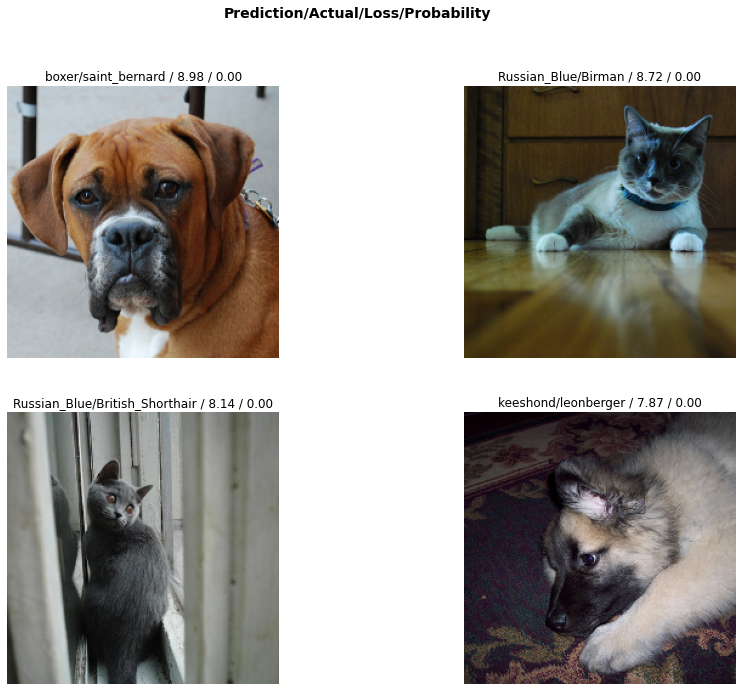

In [ ]:
interp.plot_top_losses(4, figsize=(15,11))
# Question 10. The above statement displays the images in the validation dataset
# whose losses are great, more precisely whose losses belong to top 4. 
# 10.1) What does "boxer/saint_bernard/8.98/0.00" above the first picture below
# mean? You can examine what the statement does by typing "interp.plot_top_losses??"
# in the cell and execute it. The doc says: the last value "0.00" refers to
# "the predicted probability assigned to the true class of the item (the first picture).”  
# In this case, the true class of the item is "saint_bernard".

#The title of this image shows: prediction class, actual class, loss, probability of actual class.
#boxer=prediction class, saint_bernard= actual class, 8.98=loss, 0.00=probability of actual class

# (10.2)  What does it mean that the predicted probability of this item is 0.00? 
# Does it tell something how the neural net predicts that the picture is "boxer"
#  when in fact it is "saint_bernard"?

#It means the computer predictet that image to be class "boxer" but the picture's real label 
#is "saint_bernard". It has been wrongly classified 8.98 times, and the probability the model 
#assignend to the this image of being it's actual class (sain_bernard) is 0.00.


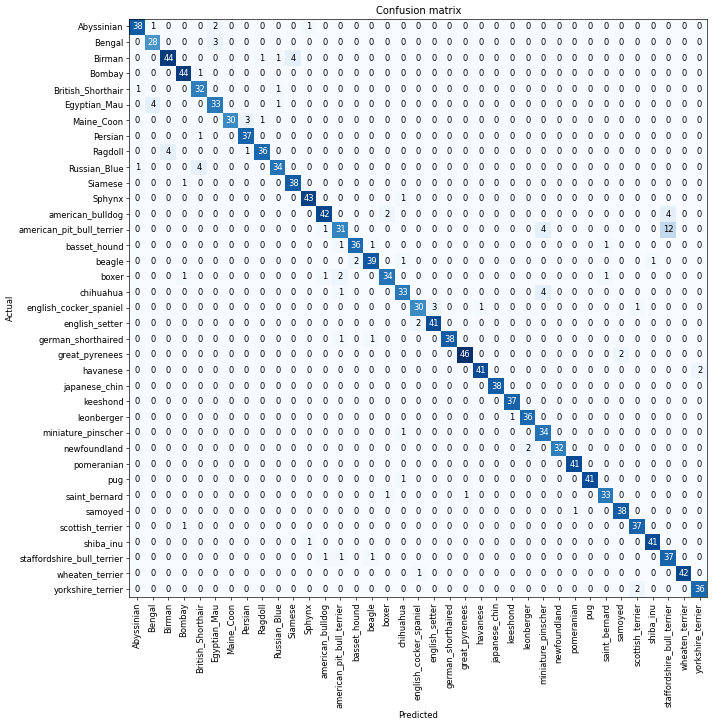

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
# Question 11: 11.1) The follwing 37 x 37 matrix is the result of executing the above statement
# If you add up all the numbers in the cells of the matrix, what would it be?
# I recommend you just guess this number without counting the numbers in each cell.

#1478


# 11.2) What do the numbers in the diagonal of the matrix represent?

#The confusion matrix shows for every actual type of dog or cat, how many times the  
#predicted to be that dog or cat. The diagonal basically shows how many times the model 
#predicted correctly, which in this case is most of the time.



In [ ]:
interp.most_confused(min_val=2)
# Question 12: The following is the result of executing the above statement.
# 12.1) In  ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 12),
#  what does number 12 refer to? 

#"most_confused" shows the particular combinations of predicted class and actual class 
#that the model got wrong the most often. So in this case,  ('american_pit_bull_terrier', 
#'staffordshire_bull_terrier', 12):
 
#Actual class: 'american_pit_bull_terrier'
#Prediction class:  'staffordshire_bull_terrier'
#This particular combination happened 12 times.


[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 12),
 ('Birman', 'Siamese', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Ragdoll', 'Birman', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('american_pit_bull_terrier', 'miniature_pinscher', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Maine_Coon', 'Persian', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('Abyssinian', 'Egyptian_Mau', 2),
 ('american_bulldog', 'boxer', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_pit_bull_terrier', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('great_pyrenees', 'samoyed', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('newfoundland', 'leonberger', 2),
 ('yorkshire_terrier', 'scottish_terrier', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)


In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()
# 

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))


In [ ]:
learn.fit_one_cycle??


Object `learn.fit_one_cycle` not found.


In [ ]:
learn.lr_range??


Object `learn.lr_range` not found.


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes